# CNO Example

This notebook provides an example of creating a simple CNO network by evaluating which rates might be important.  It then shows how to integrate the network in python.


In [1]:
import pynucastro as pyna

We start by reading in the entire Reaclib library.  We then filter it to return a `Library` that just has the rates
linking the core set of nuclei in CNO, plus the proton and alpha.

We use this to make a `PythonNetwork`

In [2]:
rl = pyna.ReacLibLibrary()
lib = rl.linking_nuclei(["p", "he4",
                           "c12", "c13",
                           "n13", "n14", "n15",
                           "o15"])
pynet = pyna.PythonNetwork(libraries=[lib])

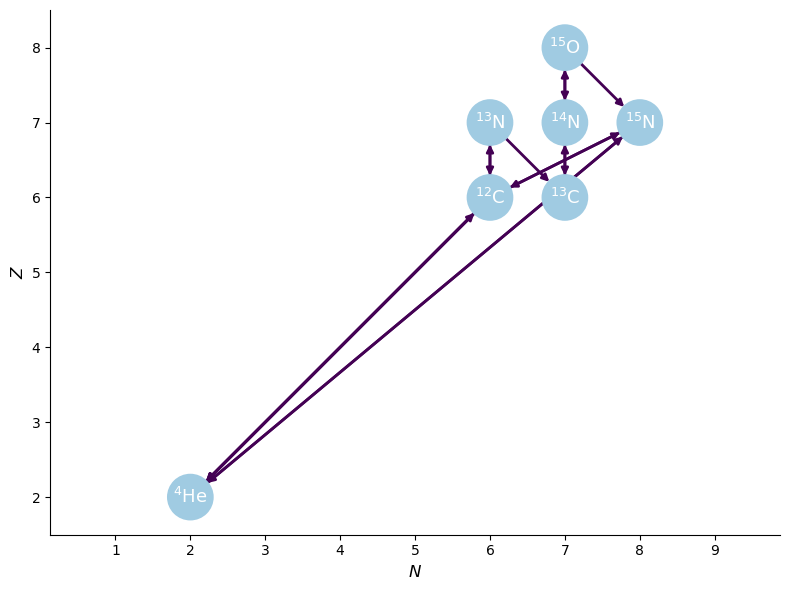

In [3]:
pynet.plot(outfile="cno_first.pdf")

Now we'll define a thermodynamic state -- the composition is set by creating a `Composition` object.

In [4]:
comp = pyna.Composition(pynet.get_nuclei())
comp.set_solar_like()
density = 150
temperature = 2.e7

we can redo the plot, passing in the thermodynamic state to see the strength of each rate.

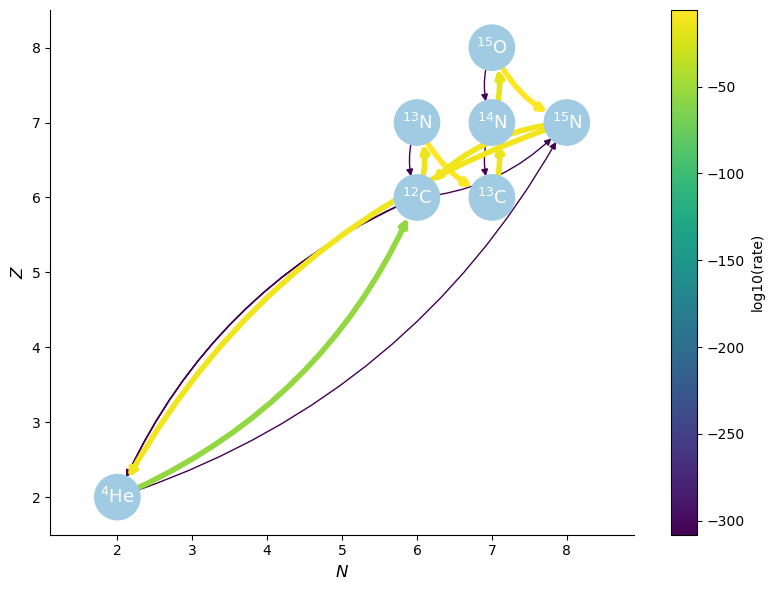

In [5]:
pynet.plot(T=temperature, rho=density, comp=comp,
           curved_edges=True,
           outfile="cno_first_comp.pdf")

`find_unimportant_rates()` takes a tuple of a thermodynamic state and a tolerance and returns all of the rates that never get within that tolerance of the fastest rate in the network.

In [6]:
state = (density, temperature, comp)
srates = pynet.find_unimportant_rates([state], 1.e-20)

In [7]:
srates

{N13 ⟶ p + C12: 0,
 N14 ⟶ p + C13: 0,
 O15 ⟶ p + N14: 0,
 C12 ⟶ He4 + He4 + He4: 0,
 C12 + He4 ⟶ p + N15: 0,
 He4 + He4 + He4 ⟶ C12 + 𝛾: 1.0175009933369637e-49}

We can pass this dictionary to `remove_rates()` to remove them from our network

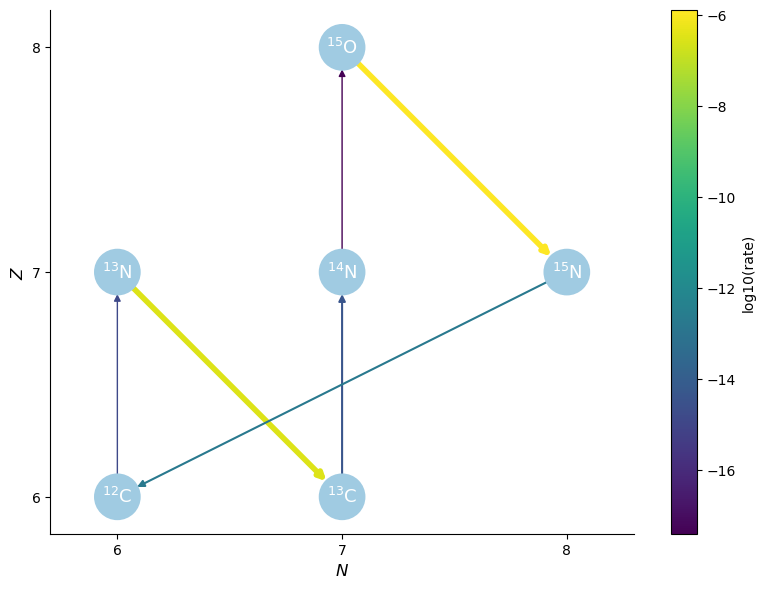

In [8]:
pynet.remove_rates(srates)
pynet.plot(T=temperature, rho=density, comp=comp, outfile="cno_filtered.pdf")

Finally, we can write out the python code needed to integrate the network and integrate it using SciPy's `solve_ivp()`

In [9]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In [10]:
pynet.write_network("cno.py")

In [11]:
import cno

In [12]:
rho = 150
T = 2.e7

X0 = np.zeros(cno.nnuc)
X0[cno.jp] = 0.7
X0[cno.jhe4] = 0.28
X0[cno.jc12] = 0.02

Y0 = X0/cno.A

tmax = 1.e20

sol = solve_ivp(cno.rhs, [0, tmax], Y0, method="BDF", jac=cno.jacobian,
                dense_output=True, args=(rho, T), rtol=1.e-6, atol=1.e-8)

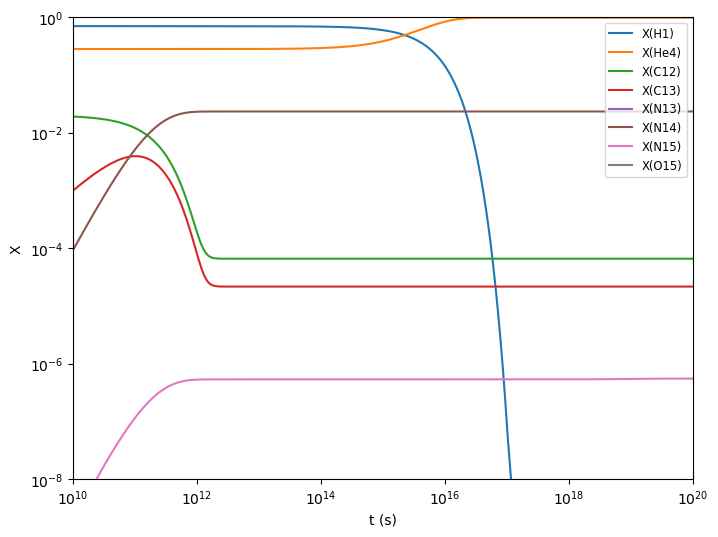

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)

for i in range(cno.nnuc):
    ax.loglog(sol.t, sol.y[i,:] * cno.A[i], label=f"X({cno.names[i].capitalize()})")

ax.set_xlim(1.e10, 1.e20)
ax.set_ylim(1.e-8, 1.0)
ax.legend(fontsize="small")
ax.set_xlabel("t (s)")
ax.set_ylabel("X")

fig.set_size_inches((8, 6))

In [14]:
fig.tight_layout()
fig.savefig("cno_integration.pdf", bbox_inches="tight")